In [13]:
#main data analysis

#\t for each cell
#\n for new line

import csv
from itertools import combinations
import numpy as np
import scipy
from scipy.stats.stats import pearsonr #returns Pearson's correlation coefficient, 2-tailed p-value
from scipy.stats.stats import spearmanr #returns Spearman's correlation coefficient, 2-tailed p-value
import seaborn as sns
import operator
import matplotlib.pyplot as plt
import matplotlib
import math

#returns mutation, gene, study, sample
def read(file, empty):
    with open(file, newline = '') as GBM_data:
        lineID = 0
        headings = []
        mutations = []
        lines = csv.reader(GBM_data, delimiter='\n')
        for line in lines:
            cell = csv.reader(line, delimiter='\t')
            for info in cell:
                foo = info[0]
                bar = info[1]
                columnID = 0
                if lineID == 0:
                    headings.append(info)
                    titles = headings[0]
                    title1 = titles[0]
                    title2 = titles[1]
                for data in info:
                    output = []
                    if (data != empty) & (lineID != 0) & (columnID != 0) & (columnID != 1):
                        #print ("Mutation: ", data,"Gene: ", titles[columnID], title1 ,": ", foo, title2,": ", bar)
                        output.append(data)
                        output.append(titles[columnID])
                        output.append(foo)
                        output.append(bar)
                        #print (output)
                        mutations.append(output)
                    columnID += 1
            lineID +=1
    return mutations

#outputs similar genes
def getGenes(data, file):
    genes = []
    for i in data:
        gene = i[1]
        genes.append(gene)
    genes = list(dict.fromkeys(genes))
    
    #print (genes)
    with open(file, newline = '') as RNA_data:
        geneID = []
        lines = csv.reader(RNA_data, delimiter='\n')
        for line in lines:
            cell = csv.reader(line, delimiter='\t')
            for info in cell:
                columnID = 0
                for data in info: #going through cell by cell
                    if columnID == 0:
                        for name in genes:
                            if name in data:
                                geneID.append(data)
                columnID += 1
    return geneID

#returns [[gene, expression level 1, 2, 3,...], [gene2, exp1, 2, 3,...],...]
def RNAexp(genes, file):
    output = []
    with open(file, newline = '') as RNA_data:
        lines = csv.reader(RNA_data, delimiter='\n')
        for line in lines:
            cell = list(csv.reader(line, delimiter='\t'))
            for info in cell:
                for i in genes:
                    if info[0] == i:
                        things = []
                        for data in info:
                            things.append(data)
                        output.append(things)
    return output

def writeFile(file, data):
    f = open(file,'w')
    f.write("Gene" + "\t" + "Log2 Expression Level")
    f.write("\n")
    for i in data:
        count = 0
        for n in i:
            if count != 0:
                try:
                    f.write("%s\t" % float(n))
                except ValueError:
                    f.write("%s\t" % n)
            else:
                f.write("%s\t" % n)
            count +=1
        f.write("\n")
    f.close()
    
def toFloat(data): #takes in singular set of [gene, exp1, exp2,...], returns ['gene', [exp1,exp2,...]] with exp as float
    output = []
    gene = data[0]
    for i in data[1:]:
        try:
            output.append(float(i))
        except ValueError:
            output.append(0) #this might screw with the results, let's see...
            gene = "null"
    return gene, output

#takes in output of RNAexp, ie [[gene, expression level 1, 2, 3,...], [gene2, exp1, 2, 3,...],...]
def correlation(data):
    comb = list(combinations(np.arange(0,len(data),1),2))
    relationship = {}
    for n in comb:
        gene1, exp1 = toFloat(data[n[0]])
        gene2, exp2 = toFloat(data[n[1]])
        corr, p = scipy.stats.pearsonr(exp1, exp2)
        relationship[gene1 + ", " + gene2] = corr
    return relationship

def corrRanked(data):
    comb = list(combinations(np.arange(0,len(data),1),2))
    relationship = {}
    for n in comb:
        gene1, exp1 = toFloat(data[n[0]])
        gene2, exp2 = toFloat(data[n[1]])
        corr, p = scipy.stats.spearmanr(exp1, exp2)
        relationship[gene1 + ", " + gene2] = corr
    return relationship

#writes GINML file with specified nodes and edges
def WriteGINML(corr_data, outfile):
        PathwayID = "MAPK_corr" #just name of system
        ProteinList = nodes(corr_data)
        AllEdges = edges(corr_data)

        f = open('{0}.ginml'.format(outfile), 'w')
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write('<!DOCTYPE gxl SYSTEM "http://ginsim.org/GINML_2_2.dtd">\n')
        f.write('<gxl xmlns:xlink="http://www.w3.org/1999/xlink">\n')
        lineadd = '  <graph class="regulatory" id="' + PathwayID + '" nodeorder="' + ' '.join(ProteinList) + '">\n'
        f.write(lineadd)
        f.write('\n')
        f.write('    <nodestyle background="#ffffff" foreground="#000000" text="#000000" shape="RECTANGLE" width="45" height="25"/>\n')
        f.write('    <nodestyle background="#ffffff" foreground="#000000" text="#000000" shape="RECTANGLE" width="45" height="25"/>\n')
        f.write('    <edgestyle color="#000000" pattern="SIMPLE" line_width="1" properties="positive:#00c800 negative:#c80000 dual:#0000c8"/>\n')
        f.write('    <edgestyle color="#000000" pattern="SIMPLE" line_width="1" properties="positive:#00c800 negative:#c80000 dual:#0000c8"/>\n')
        f.write('\n')

        for i in range(len(ProteinList)):
            lineadd2 = '    <node id="' + ProteinList[i] + '" maxvalue="1">\n'
            f.write(lineadd2)
            f.write('      <value val="1">\n' + '      </value>\n')

            r = 300                                     #300 is an arbitrary value for now, will make it a function of node number
            x = r + (-1)*r*math.cos((i/len(ProteinList))*2*math.pi)   #This defines position of the x coordinate
            y = r + (-1)*r*math.sin((i/len(ProteinList))*2*math.pi)   #This defines position of the y coordinate
            f.write('      <nodevisualsetting x="' + str(round(x)) + '"' + ' y="' + str(round(y)) + '" style=""/>\n') #Make a circular spread using the sin(360/len(ProteinList), make x y variable
            f.write('    </node>\n')                                           #Turn x and y into variables

        f.write('\n')

        for i in range(len(AllEdges)):
            lineadd3 = '    <edge id="' + AllEdges[i][0] + ':' + AllEdges[i][1] + '" from="' + AllEdges[i][0] + '" to="' + AllEdges[i][1] + '" minvalue="1" sign="' + AllEdges[i][2] + '">\n'
            f.write(lineadd3)
            f.write('      <edgevisualsetting style=""/>\n')
            f.write('    </edge>\n')

        f.write('\n')
        f.write('  </graph>\n')
        f.write('</gxl>')
        f.close()

        
#takes in result of corr functions and returns list of genes invovled in relationships with r >= 0.6
def nodes(data):
    nodes = []
    for i in range(len(data)):
        #print (abs(data[i][1]))
        if 1 > abs(data[i][1]) >= 0.6:
            split = [x.strip() for x in sorted_corrsR[i][0].split(',')]
            #print (split[0])
            if (split[0] != "null") & (split[1] != "null"):
                nodes.append(split[0])
                nodes.append(split[1])
    nodes = list(dict.fromkeys(nodes))
    return nodes

#takes in result of corr functions and returns list of lists of gene1, gene2, positive/negative
def edges(data):
    edges = []
    for i in range(len(data)):
        edge = []
        if 1 > data[i][1] >= 0.6:
            split = [x.strip() for x in sorted_corrsR[i][0].split(',')]
            if (split[0] != "null") & (split[1] != "null"):
                edge.append(split[0])
                edge.append(split[1])
                edge.append("positive")
                edges.append(edge)
        if -1 < data[i][1] <= -0.6:
            split = [x.strip() for x in sorted_corrsR[i][0].split(',')]
            if (split[0] != "null") & (split[1] != "null"):
                edge.append(split[0])
                edge.append(split[1])
                edge.append("negative")
                edges.append(edge)
    return edges

In [14]:
data = read("/Users/collinjlarkin/MSc_project/GenomeData/mutations.txt", "NA")
file = "/Users/collinjlarkin/MSc_project/GenomeData/GBMnormalized.txt"
destFile = "/Users/collinjlarkin/MSc_project/GenomeData/test.txt"
commonGenes = getGenes(data, file)
rna = RNAexp(commonGenes, file)
#print (rna[0])
writeFile(destFile,rna)

In [15]:
corrsR = corrRanked(rna)
sorted_corrsR = sorted(corrsR.items(), key=operator.itemgetter(1))

#print (sorted_corrsR)

In [16]:
print (sorted_corrsR[0])
nodes(sorted_corrsR)

('HEATR5B|54497, PRELID1|27166', -0.8010607915136679)


['HEATR5B|54497',
 'PRELID1|27166',
 'MAPK8IP3|23162',
 'MYCBP|26292',
 'ATRN|8455',
 'TAOK1|57551',
 'MAP3K13|9175',
 'TP53TG1|11257',
 'BCL2L12|83596',
 'HIPK2|28996',
 'GSK3B|2932',
 'ATRX|546',
 'MATR3|9782',
 'RELB|5971',
 'BAX|581',
 'MAP3K11|4296',
 'MAP3K10|4294',
 'MYCBP2|23077',
 'MYCN|4613',
 'RAF1|5894',
 'MAPK8IP2|23542',
 'ATM|472',
 'ATR|545',
 'TP53I13|90313',
 'NFKB1|4790',
 'MAPK8IP1|9479',
 'MTOR|2475',
 'MAPK11|5600',
 'MAPK12|6300',
 'TAOK2|9344',
 'NFKB2|4791',
 'BCL2A1|597',
 'MAPK13|5603',
 'BRAF|673',
 'CDKN2AIPNL|91368',
 'PTENP1|11191',
 'PTEN|5728']

In [17]:
edges(sorted_corrsR)

[['HEATR5B|54497', 'PRELID1|27166', 'negative'],
 ['MAPK8IP3|23162', 'MYCBP|26292', 'negative'],
 ['ATRN|8455', 'PRELID1|27166', 'negative'],
 ['PRELID1|27166', 'TAOK1|57551', 'negative'],
 ['MAP3K13|9175', 'TP53TG1|11257', 'negative'],
 ['BCL2L12|83596', 'HIPK2|28996', 'negative'],
 ['GSK3B|2932', 'TP53TG1|11257', 'negative'],
 ['ATRX|546', 'PRELID1|27166', 'negative'],
 ['MATR3|9782', 'RELB|5971', 'negative'],
 ['HIPK2|28996', 'MYCBP|26292', 'negative'],
 ['BAX|581', 'HEATR5B|54497', 'negative'],
 ['MAP3K11|4296', 'MATR3|9782', 'negative'],
 ['MAP3K10|4294', 'MYCBP|26292', 'negative'],
 ['ATRN|8455', 'HEATR5B|54497', 'positive'],
 ['HEATR5B|54497', 'MYCBP2|23077', 'positive'],
 ['MYCN|4613', 'RAF1|5894', 'positive'],
 ['MAPK8IP2|23542', 'MAPK8IP3|23162', 'positive'],
 ['ATM|472', 'HEATR5B|54497', 'positive'],
 ['ATM|472', 'ATR|545', 'positive'],
 ['MAP3K13|9175', 'TAOK1|57551', 'positive'],
 ['GSK3B|2932', 'MAP3K13|9175', 'positive'],
 ['HEATR5B|54497', 'HIPK2|28996', 'positive'],
 [

In [18]:
WriteGINML(sorted_corrsR,"MAPKtest")

/Users/collinjlarkin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


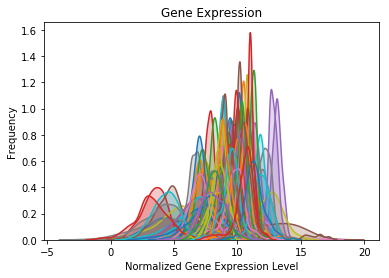

105


In [19]:
count = 0
for i in range(len(rna)):
    gene1, exp1 = toFloat(rna[i])
    if gene1 != "null":
        count += 1
        e1 = sns.kdeplot(exp1, shade="True")
plt.title("Gene Expression")
plt.xlabel("Normalized Gene Expression Level")
plt.ylabel("Frequency")
plt.show()
print (count)

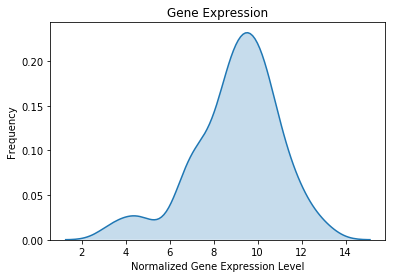

In [20]:
avg = []
for i in range(len(rna)):
    gene1, exp1 = toFloat(rna[i])
    if gene1 != "null":
        avg.append(np.mean(exp1))
e1 = sns.kdeplot(avg, shade="True")
plt.title("Gene Expression")
plt.xlabel("Normalized Gene Expression Level")
plt.ylabel("Frequency")
plt.show()

In [21]:
#should be tumor suppressors
lowGenes = []
for i in range(len(rna)):
    gene, exp = toFloat(rna[i])
    if gene != 'null':
        for n in exp:
            if n < 5.5:
                lowGenes.append(gene)
    lowGenes = list(dict.fromkeys(lowGenes))

print (lowGenes)

['ATRNL1|26033', 'BCL2A1|597', 'BCL2L12|83596', 'BCL2L15|440603', 'BRAF|673', 'CDKN2A|1029', 'CHEK2|11200', 'FGFR3|2261', 'KIRREL2|84063', 'KIRREL|55243', 'LEPREL1|55214', 'LEPREL2|10536', 'MAP3K13|9175', 'MAPK10|5602', 'MAPK13|5603', 'MAPK8IP2|23542', 'MYCL1|4610', 'MYCN|4613', 'MYCT1|80177', 'PRELID2|153768', 'RELL2|285613', 'RELN|5649', 'REL|5966', 'TAOK1|57551', 'TP53AIP1|63970', 'TRAF1|7185']


In [22]:
#should be oncogenes
highGenes = []
for i in range(len(rna)):
    gene, exp = toFloat(rna[i])
    if gene != 'null':
        for n in exp:
            if n > 9.5:
                highGenes.append(gene)
    highGenes = list(dict.fromkeys(highGenes))

print (highGenes)

['ARAF|369', 'ATMIN|23300', 'ATM|472', 'ATRNL1|26033', 'ATRN|8455', 'ATRX|546', 'ATR|545', 'BAX|581', 'BCL2A1|597', 'BCL2L11|10018', 'BCL2L12|83596', 'BCL2L13|23786', 'BCL2L1|598', 'BCL2L2|599', 'BCL2|596', 'CDKN2AIPNL|91368', 'CDKN2AIP|55602', 'CDKN2A|1029', 'CRELD1|78987', 'CRELD2|79174', 'CTNNB1|1499', 'EGFR|1956', 'FGFR3|2261', 'GADD45B|4616', 'GATM|2628', 'GSK3B|2932', 'HEATR1|55127', 'HEATR2|54919', 'HEATR5A|25938', 'HEATR5B|54497', 'HEATR6|63897', 'HEATR7A|727957', 'HIPK2|28996', 'KIRREL|55243', 'LEPREL1|55214', 'LEPREL2|10536', 'MAP3K10|4294', 'MAP3K11|4296', 'MAP3K12|7786', 'MAP3K14|9020', 'MAP3K1|4214', 'MAPK10|5602', 'MAPK11|5600', 'MAPK12|6300', 'MAPK14|1432', 'MAPK1IP1L|93487', 'MAPK1|5594', 'MAPK3|5595', 'MAPK8IP1|9479', 'MAPK8IP2|23542', 'MAPK8IP3|23162', 'MAPK8|5599', 'MAPK9|5601', 'MATR3|9782', 'MDM2|4193', 'MTOR|2475', 'MYCBP2|23077', 'MYCBP|26292', 'MYCL1|4610', 'MYCN|4613', 'MYC|4609', 'NFKB1|4790', 'NFKB2|4791', 'NRAS|4893', 'PRELID1|27166', 'PRELP|5549', 'PRKDC|55

In [23]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

intersection(lowGenes,highGenes)

['ATRNL1|26033',
 'BCL2A1|597',
 'BCL2L12|83596',
 'CDKN2A|1029',
 'FGFR3|2261',
 'KIRREL|55243',
 'LEPREL1|55214',
 'LEPREL2|10536',
 'MAPK10|5602',
 'MAPK8IP2|23542',
 'MYCL1|4610',
 'MYCN|4613',
 'RELL2|285613',
 'RELN|5649',
 'TAOK1|57551',
 'TRAF1|7185']

In [24]:
#there really isn't a good way to do this that I can think of... usual brute force won't work due to differences in names of genes and nodes

ognet = open("/Users/collinjlarkin/MSc_project/GinSim_work/GINsim-data/regulatoryGraph.ginml", "r")
corrnet = open("/Users/collinjlarkin/MSc_project/MAPKtest.ginml", "r")

def all_extract(line, subs, sube):
    var = ''
    if subs in line:
        var = line.replace(subs,"").replace(sube,"")
        #print ("all_extract: ", var)
    return var

def names(corrnet):
    edges = []
    for line in corrnet:
        edge = []
        begin = '<edge id="'
        end = '">'
        var2 = all_extract(line, begin, end)
        if var2 != '':
            words = var2.rstrip()
            rel,frm,to,mn,sign, = words.split()
            strp = frm.strip("from=")
            fin = strp.strip('"')
            gene1, code1 = fin.split('|')
            #print ("gene1 = ", gene1)
            strp = to.strip("to=")
            fin = strp.strip('"')
            gene2, code2 = fin.split('|')
            #print ("gene2 = ", gene2)
            sign = sign.strip('sign=')
            sign = sign.strip('"')
            edge.append(gene1)
            edge.append(gene2)
            edge.append(sign)
            edges.append(edge)
    return edges
names(corrnet)

[['HEATR5B', 'PRELID1', 'negative'],
 ['MAPK8IP3', 'MYCBP', 'negative'],
 ['ATRN', 'PRELID1', 'negative'],
 ['PRELID1', 'TAOK1', 'negative'],
 ['MAP3K13', 'TP53TG1', 'negative'],
 ['BCL2L12', 'HIPK2', 'negative'],
 ['GSK3B', 'TP53TG1', 'negative'],
 ['ATRX', 'PRELID1', 'negative'],
 ['MATR3', 'RELB', 'negative'],
 ['HIPK2', 'MYCBP', 'negative'],
 ['BAX', 'HEATR5B', 'negative'],
 ['MAP3K11', 'MATR3', 'negative'],
 ['MAP3K10', 'MYCBP', 'negative'],
 ['ATRN', 'HEATR5B', 'positive'],
 ['HEATR5B', 'MYCBP2', 'positive'],
 ['MYCN', 'RAF1', 'positive'],
 ['MAPK8IP2', 'MAPK8IP3', 'positive'],
 ['ATM', 'HEATR5B', 'positive'],
 ['ATM', 'ATR', 'positive'],
 ['MAP3K13', 'TAOK1', 'positive'],
 ['GSK3B', 'MAP3K13', 'positive'],
 ['HEATR5B', 'HIPK2', 'positive'],
 ['BCL2L12', 'MYCBP', 'positive'],
 ['GSK3B', 'HEATR5B', 'positive'],
 ['BCL2L12', 'TP53I13', 'positive'],
 ['NFKB1', 'RELB', 'positive'],
 ['MAPK8IP1', 'MAPK8IP2', 'positive'],
 ['HEATR5B', 'MTOR', 'positive'],
 ['MAPK11', 'MAPK12', 'positiv